In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from glob import glob

import librosa, librosa.display
import IPython.display as ipd
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import os

zip_path = "/content/drive/My Drive/MachineLearning/Colab data/VoxCeleb_gender.zip"

extract_path = '/content/unzipped_data'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


# Data exploration

In [ ]:
males_data = glob('/content/unzipped_data/VoxCeleb_gender/males/*')
females_data = glob('/content/unzipped_data/VoxCeleb_gender/females/*')
len(males_data), len(females_data)

(3682, 2311)

In [ ]:
# test a male audio file
males_data[0]

'/content/unzipped_data/VoxCeleb_gender/males/796.m4a'

In [ ]:
y, sr = librosa.load(males_data[0], sr=None)
print(f"Shape of y: {y.shape}")
print(f"Sample rate: {sr}")
print(f"Duration of audio: {librosa.get_duration(y=y, sr=sr)} seconds")
print(f"y itself: {y[:10]}")

Shape of y: (89088,)
Sample rate: 16000
Duration of audio: 5.568 seconds
y itself: [-0.07058716 -0.07519531 -0.0604248  -0.04211426 -0.02896118  0.01141357
  0.02459717  0.019104   -0.02127075 -0.04940796]


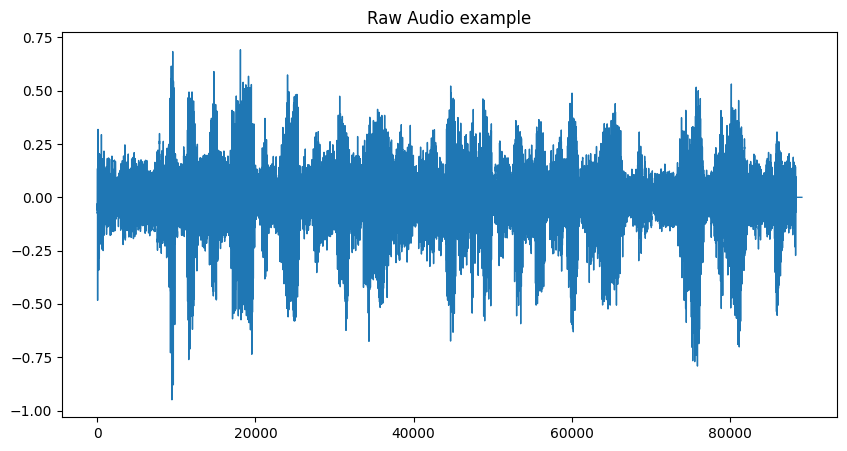

In [ ]:
pd.Series(y).plot(figsize=(10, 5),
                  lw=1,
                  title="Raw Audio example")
plt.show()

In [ ]:
# test a female audio file
ipd.Audio(females_data[2])

In [ ]:
y, sr = librosa.load(females_data[2])
print(f"Shape of y: {y.shape}")
print(f"Sample rate: {sr}")
print(f"Duration of audio: {librosa.get_duration(y=y, sr=sr)} seconds")
print(f"y itself: {y[:10]}")

Shape of y: (138298,)
Sample rate: 22050
Duration of audio: 6.272018140589569 seconds
y itself: [ 0.24249703  0.31371248  0.3083152   0.3221162   0.29437953  0.22460619
  0.16750687  0.08516347 -0.01413598 -0.08627422]


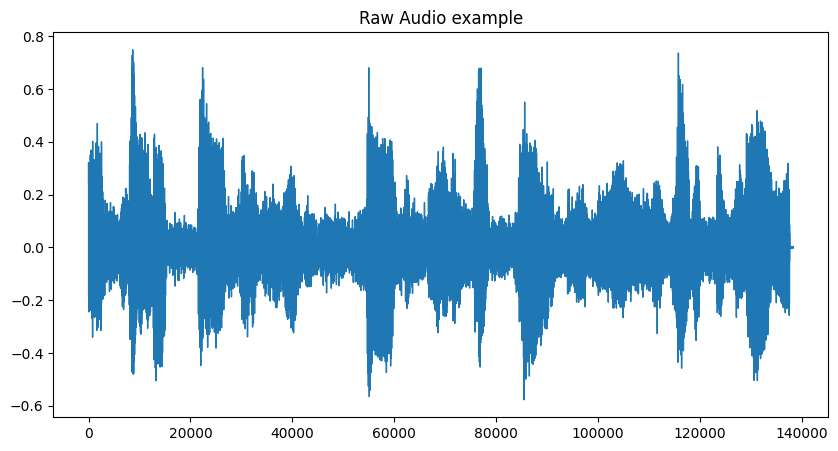

In [ ]:
pd.Series(y).plot(figsize=(10, 5),
                  lw=1,
                  title="Raw Audio example")
plt.show()

### Noise reduction

In [ ]:
!pip install noisereduce

In [ ]:
import noisereduce as nr

y_reduced, srr = librosa.load(males_data[0], sr=None)
reduced_noise = nr.reduce_noise(y=y, sr=srr)
ipd.Audio(reduced_noise, rate=sr)

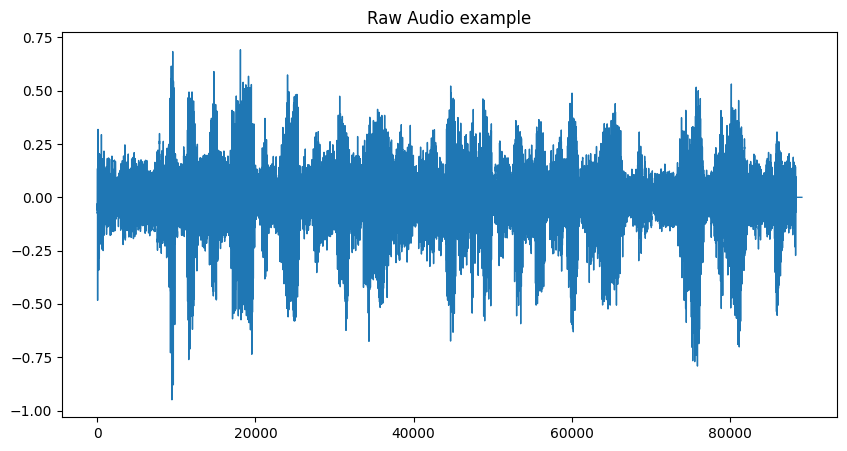

In [ ]:
pd.Series(y).plot(figsize=(10, 5),
                  lw=1,
                  title="Raw Audio example")
plt.show()

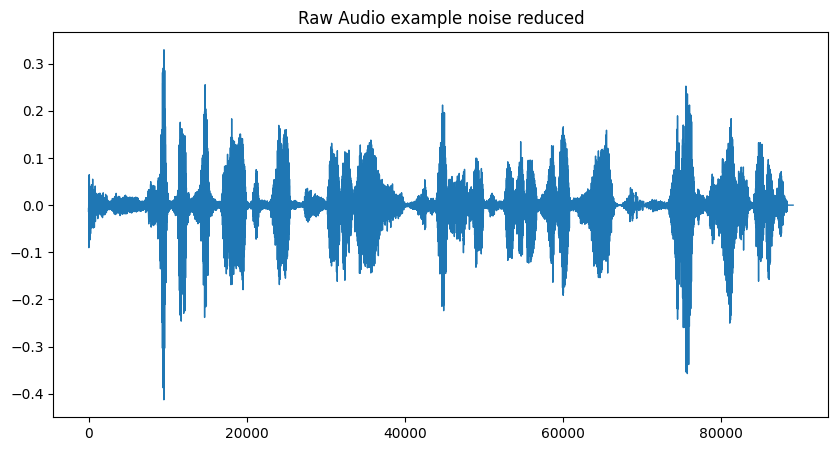

In [ ]:
pd.Series(reduced_noise).plot(figsize=(10, 5),
                  lw=1,
                  title="Raw Audio example noise reduced")
plt.show()

In [ ]:
reduced_noise[:10]

array([-0.00806595, -0.01169024, -0.0145164 , -0.01437659, -0.01263245,
       -0.00859166, -0.00624064, -0.00551469, -0.00816209, -0.01070898],
      dtype=float32)

In [ ]:
y[:10]

array([-0.07058716, -0.07519531, -0.0604248 , -0.04211426, -0.02896118,
        0.01141357,  0.02459717,  0.019104  , -0.02127075, -0.04940796],
      dtype=float32)

In [ ]:
ipd.Audio(y, rate=sr)

In [ ]:
ipd.Audio(reduced_noise, rate=srr)

### cleaning data

In [ ]:
def data_preprocessing(audio_file):
  #noise reduce
  y, sr = librosa.load(audio_file, sr=None)
  y_reduced = nr.reduce_noise(y=y, sr=sr)
  #silence removal
  y = librosa.effects.trim(y_reduced, top_db=30)[0]
  return y

In [ ]:
cleaned_data = []
for audio in males_data:
  cleaned_data.append([data_preprocessing(audio), 'male'])
for audio in females_data:
  cleaned_data.append([data_preprocessing(audio), 'female'])


In [ ]:
print(cleaned_data[0][1])

male


In [ ]:
# saving cleaned dataset
import soundfile as sf
output_folder_males = '/content/drive/My Drive/MachineLearning/Colab data/cleaned_dataset/males'
output_folder_females = '/content/drive/My Drive/MachineLearning/Colab data/cleaned_dataset/females'

os.makedirs(output_folder_males, exist_ok=True)
os.makedirs(output_folder_females, exist_ok=True)

i = 0
for data in cleaned_data:
  if data[1] == 'male':
    sf.write(os.path.join(output_folder_males, f'audio_{i}.wav'), data[0], 16500)
  else:
    sf.write(os.path.join(output_folder_females, f'audio_{i}.wav'), data[0], 16500)
  i += 1


We saved the cleaned dataset in the drive in order to be able to use it if we restarted the session.

In [ ]:
ipd.Audio(cleaned_data[4000][0], rate=16500)

In [ ]:
#Loading the cleaned dataset
cleaned_males = glob('/content/drive/My Drive/MachineLearning/Colab data/cleaned_dataset/males/*')
cleaned_females = glob('/content/drive/My Drive/MachineLearning/Colab data/cleaned_dataset/females/*')

#Features Extraction

In [ ]:
# feature extraction
features_list = []
for audio in cleaned_males:
  audio = librosa.load(audio, sr=14500)
  #Mel-frequency mestral coefficients: captures vocal shape
  mfcc = librosa.feature.mfcc(y=audio[0], sr=14500, n_mfcc=20)
  mfcc_mean = np.mean(mfcc.T, axis=0)
  #Spectral centroid: helps in differentiating between male and female voices (females voices tend to have higher spectral centroid)
  spectral_centroid = librosa.feature.spectral_centroid(y=audio[0], sr=14500)
  centroid_mean = spectral_centroid.mean()
  features_list.append([mfcc_mean, centroid_mean, 'male'])

for audio in cleaned_females:
  audio = librosa.load(audio, sr=14500)
  #mfcc
  mfcc = librosa.feature.mfcc(y=audio[0], sr=14500, n_mfcc=20)
  mfcc_mean = np.mean(mfcc.T, axis=0)
  #spectral centroid
  spectral_centroid = librosa.feature.spectral_centroid(y=audio[0], sr=14500)
  centroid_mean = spectral_centroid.mean()
  features_list.append([mfcc_mean, centroid_mean, 'female'])

In [ ]:
df = pd.DataFrame(features_list, columns=['mfcc', 'centroid', 'label'])
df.tail()

,mfcc,centroid,label
5988,"[-347.7634, 97.00572, -24.55413, 6.274897, -27...",1614.664532,female
5989,"[-459.91214, 31.165327, -17.704473, 2.4931598,...",2281.390636,female
5990,"[-447.45297, 104.281525, -6.40199, 13.323459, ...",1604.366185,female
5991,"[-493.04065, 69.06094, 20.785162, 31.36477, -1...",2423.374966,female
5992,"[-454.0899, 81.557945, 20.217226, 17.75264, -6...",1928.198086,female


In [ ]:
df['mfcc'][0]

array([-5.8547650e+02,  1.3707797e+02,  9.7948036e+00,  1.2273837e+00,
       -4.8812046e+00, -1.2920576e+01, -2.7551512e+01, -1.0630464e+01,
       -1.0225467e+01,  5.2975732e-01,  2.4795728e+00, -6.2119517e+00,
        3.5785124e+00,  9.8371792e+00,  7.1664011e-01, -1.2912334e+00,
        2.0044835e+00, -3.5387425e+00, -8.8749428e+00, -4.6858664e+00],
      dtype=float32)

In [ ]:
mfcc = df.mfcc.tolist()
centroid = df.centroid.tolist()
X = np.hstack([np.asarray(mfcc).reshape(len(mfcc), -1), np.asarray(centroid).reshape(len(centroid), -1)])
Y = np.array(df.label.tolist())

In [ ]:
Y[0]

np.str_('male')

In [ ]:
X.shape

(5993, 21)

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
Y = le.fit_transform(Y)

In [ ]:
# Saving the numpy arrays to be able to use them later, since these are the features that we'll use in the model.
np.save('/content/drive/My Drive/MachineLearning/Colab data/features.npy', X)
np.save('/content/drive/My Drive/MachineLearning/Colab data/labels.npy', Y)

#Data preprocessing finished: Loading final data

In [2]:
X = np.load('features.npy')
Y = np.load('labels.npy')

In [ ]:
X.shape

(5993, 21)

In [ ]:
Y.shape

(5993,)

# Splitting dataset

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Naive Bayes from scratch

In [3]:
class NaiveBayes:

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self._classes = np.unique(y)
        n_classes = len(self._classes)

        # calculate mean, var, and prior for each class
        self._mean = np.zeros((n_classes, n_features), dtype=np.float64)
        self._var = np.zeros((n_classes, n_features), dtype=np.float64)
        self._priors = np.zeros(n_classes, dtype=np.float64)

        for idx, c in enumerate(self._classes):
            X_c = X[y == c]
            self._mean[idx, :] = X_c.mean(axis=0)
            self._var[idx, :] = X_c.var(axis=0)
            self._priors[idx] = X_c.shape[0] / float(n_samples)


    def predict(self, X):
        y_pred = [self._predict(x) for x in X]
        return np.array(y_pred)

    def _predict(self, x):
        posteriors = []

        # calculate posterior probability for each class
        for idx, c in enumerate(self._classes):
            prior = np.log(self._priors[idx])
            posterior = np.sum(np.log(self._pdf(idx, x)))
            posterior = posterior + prior
            posteriors.append(posterior)

        # return class with the highest posterior
        return self._classes[np.argmax(posteriors)]

    def _pdf(self, class_idx, x):
        mean = self._mean[class_idx]
        var = self._var[class_idx]
        numerator = np.exp(-((x - mean) ** 2) / (2 * var))
        denominator = np.sqrt(2 * np.pi * var)
        return numerator / denominator

In [6]:
def accuracy(y_true, y_pred):
  accuracy = np.sum(y_true == y_pred) / len(y_true)
  return accuracy

nb = NaiveBayes()
nb.fit(X_train,y_train)
predictions = nb.predict(X_test)
print("accuracy:", accuracy(y_test, predictions))

accuracy: 0.8865721434528774


# Testing built-in models on the dataset

In [ ]:
#using built-in naive bayes classifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

# Create a Naive Bayes classifier
nb_classifier = GaussianNB()

# Train the classifier
nb_classifier.fit(X_train, y_train)

GaussianNB()

In [ ]:
nb_classifier.score(X_test, y_test)

0.8865721434528774

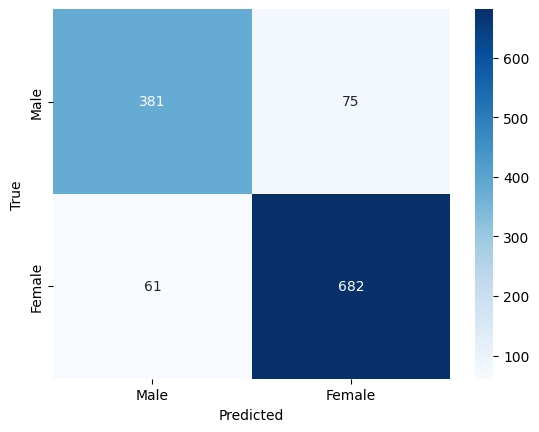

In [ ]:
from sklearn.metrics import confusion_matrix
y_pred = nb_classifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Male', 'Female'], yticklabels=['Male', 'Female'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [ ]:
len(X_test)

1199

In [ ]:
# trying svm
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Create an SVM classifier
svm_classifier = SVC(kernel='linear')

# Train the classifier
svm_classifier.fit(X_train, y_train)

SVC(kernel='linear')

In [ ]:
svm_classifier.score(X_test, y_test)

0.8940783986655546

In [ ]:
# trying logistic regression
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

In [ ]:
lr.score(X_test, y_test)

0.890742285237698

In [ ]:
# trying xgboost
import xgboost as xgb
from sklearn.metrics import accuracy_score

# Create an XGBoost classifier
xgb_classifier = xgb.XGBClassifier()

# Train the classifier
xgb_classifier.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
xgb_classifier.score(X_test, y_test)

0.8999165971643036